In [4]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.layers import Input, Dropout, Dense, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras.applications.resnet import ResNet50
from keras.applications import VGG16
from tensorboard import notebook
from tensorflow import keras 
from tensorflow.keras.applications.resnet import ResNet50
from keras.layers import Concatenate
import numpy as np
import tensorflow as tf
import sys
sys.path.append("/root/autodl-tmp/training_tool/")
from training_tool import load_data, draw_curve, draw_matrix, TimeHistory

100%|██████████| 186/186 [00:00<00:00, 195.03it/s]


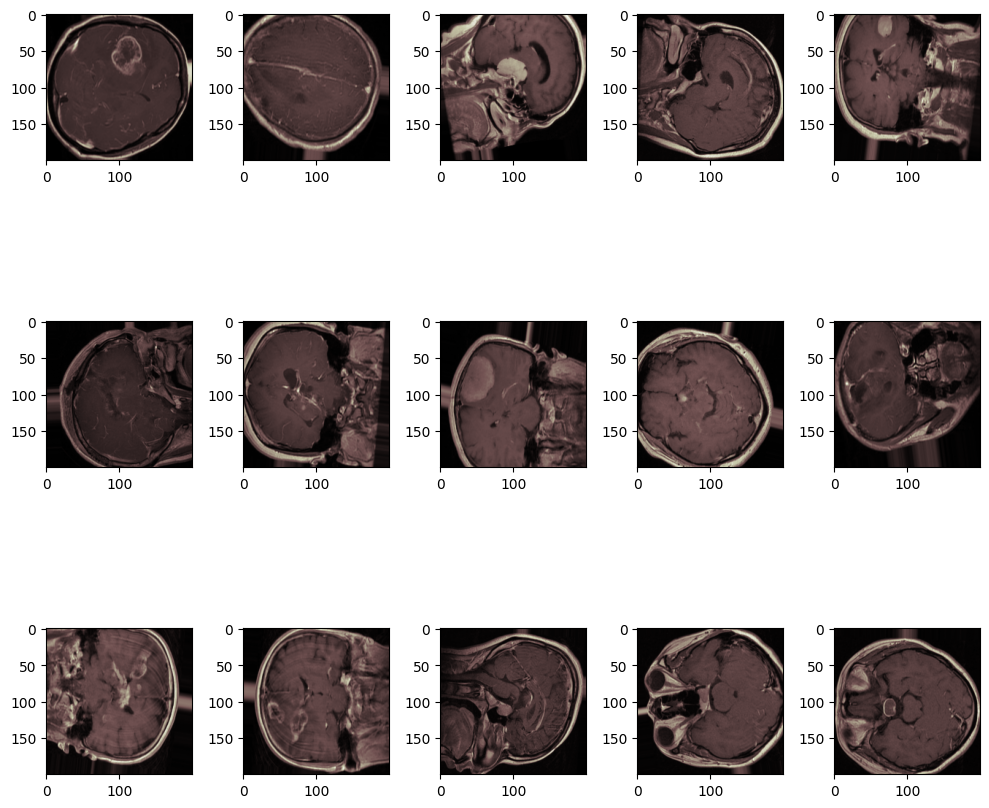

(614, 200, 200, 3)
(10536, 200, 200, 3)
(614, 3)
(10536, 3)


In [2]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)

In [5]:
def mini_block(filters, x):
    conv = tf.keras.layers.Conv2D(filters , kernel_size=(3, 3),padding = "same")(x)
    bn = tf.keras.layers.BatchNormalization()(conv)
    act = tf.keras.layers.ReLU()(bn)
    return act

def double_mini_block(filters, x):
    t = mini_block(filters, x)
    t = mini_block(filters, t)
    return t

def MFL_Block(f,inp):
    block1 = mini_block(f,inp)
    block2 = double_mini_block(f,inp)
    c1 =  Concatenate()([block1, block2])
    conv = tf.keras.layers.Conv2D(f , kernel_size=(1, 1))(c1)
    block3 = mini_block(f,conv)
    block4 = mini_block(f,inp)
    c2 = Concatenate()([block3, block4])
    conv = tf.keras.layers.Conv2D(f, kernel_size=(1, 1))(c2)
    return conv

def MFL_Net():
    inp = tf.keras.layers.Input(shape=(200,200,3))
    b1 = mini_block(16,inp)
    pool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(b1)
    p1 = MFL_Block(16,pool)
    pool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(p1)
    p2 = MFL_Block(32,pool)
    pool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(p2)
    p3 = MFL_Block(64,pool)
    pool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(p3)
    p4 = MFL_Block(128,pool)
    globavg = tf.keras.layers.GlobalAveragePooling2D()(p4)
    drop = tf.keras.layers.Dropout(rate=0.5)(globavg)
    out = tf.keras.layers.Dense(3, activation='softmax')(drop)
    model = tf.keras.Model(inputs=inp, outputs=out)
    return model

In [4]:
model = MFL_Net()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

2023-12-10 00:17:14.346475: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-10 00:17:14.666299: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22134 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:c3:00.0, compute capability: 8.9


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 200, 200, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 200, 200, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [5]:
tensorboard = TensorBoard(log_dir = 'logs')
Checkpoint = ModelCheckpoint(filepath='model-MFL_Net.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='min')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,Checkpoint,reduce_lr, time_callback])

Epoch 1/50


2023-12-10 00:17:23.065220: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2023-12-10 00:17:23.610520: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2023-12-10 00:17:23.610557: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2023-12-10 00:17:23.610737: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-12-10 00:17:24.093957: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


264/264 [==============================] - ETA: 0s - loss: 0.6439 - accuracy: 0.7262
Epoch 1: saving model to model-MFL_Net.h5
Epoch 1: 10.98 seconds
264/264 [==============================] - 11s 26ms/step - loss: 0.6439 - accuracy: 0.7262 - val_loss: 2.8538 - val_accuracy: 0.3615 - lr: 1.0000e-04
Epoch 2/50
262/264 [============================>.] - ETA: 0s - loss: 0.3794 - accuracy: 0.8562
Epoch 2: saving model to model-MFL_Net.h5
Epoch 2: 5.77 seconds
264/264 [==============================] - 6s 22ms/step - loss: 0.3791 - accuracy: 0.8564 - val_loss: 4.2342 - val_accuracy: 0.4279 - lr: 1.0000e-04
Epoch 3/50
262/264 [============================>.] - ETA: 0s - loss: 0.2830 - accuracy: 0.8941
Epoch 3: saving model to model-MFL_Net.h5
Epoch 3: 5.76 seconds
264/264 [==============================] - 6s 22ms/step - loss: 0.2823 - accuracy: 0.8944 - val_loss: 0.5809 - val_accuracy: 0.8083 - lr: 1.0000e-04
Epoch 4/50
262/264 [============================>.] - ETA: 0s - loss: 0.2277 - acc

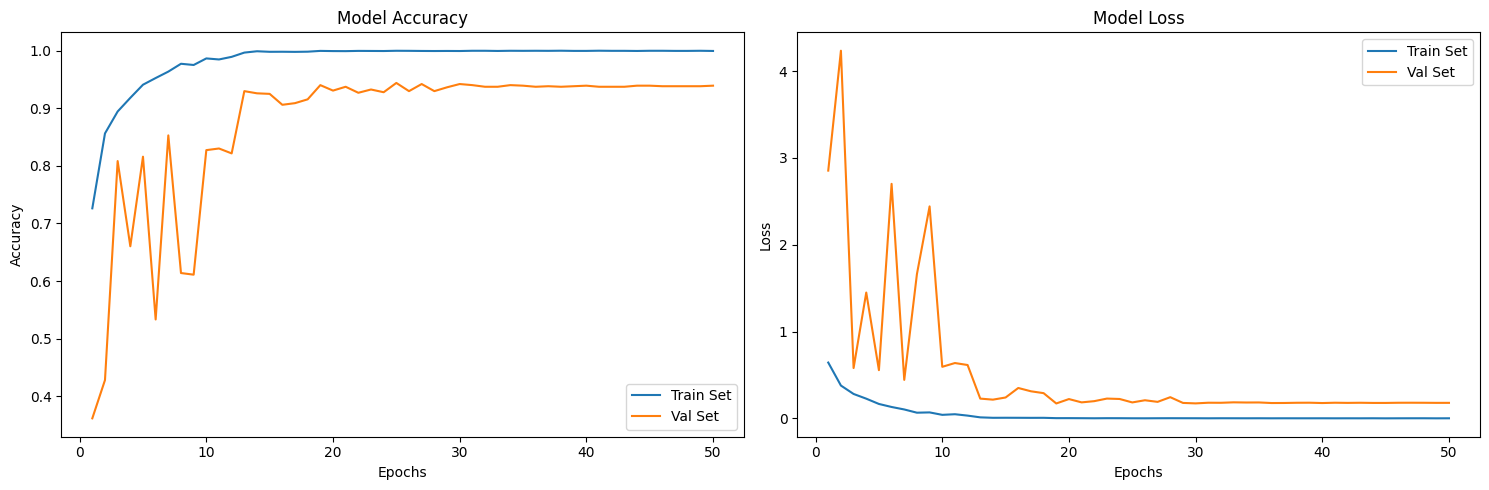

In [6]:
draw_curve(history)

20/20 [==============================] - 0s 7ms/step - loss: 0.2706 - accuracy: 0.9332
Test Accuracy:  93.32
              precision    recall  f1-score   support

      glioma     0.9670    0.9231    0.9445       286
  meningioma     0.8431    0.9085    0.8746       142
   pituitary     0.9574    0.9677    0.9626       186

    accuracy                         0.9332       614
   macro avg     0.9225    0.9331    0.9272       614
weighted avg     0.9355    0.9332    0.9338       614



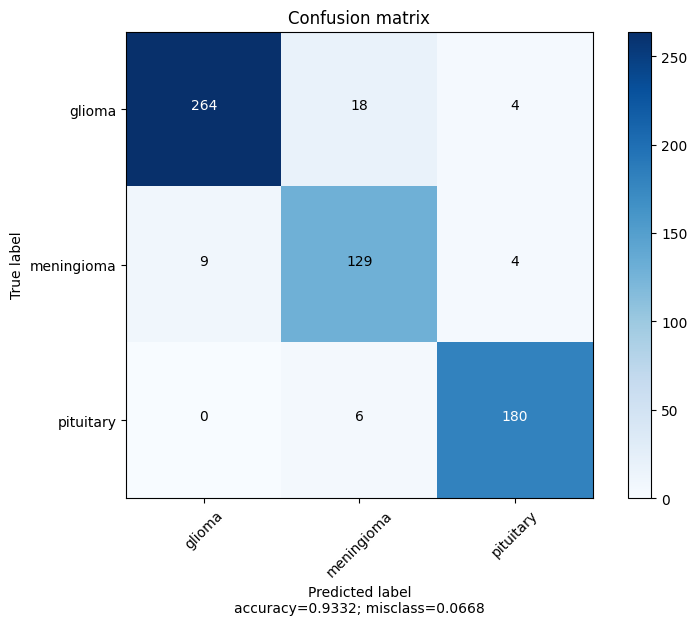

In [7]:
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

In [8]:
%reset -f

100%|██████████| 186/186 [00:00<00:00, 193.07it/s]


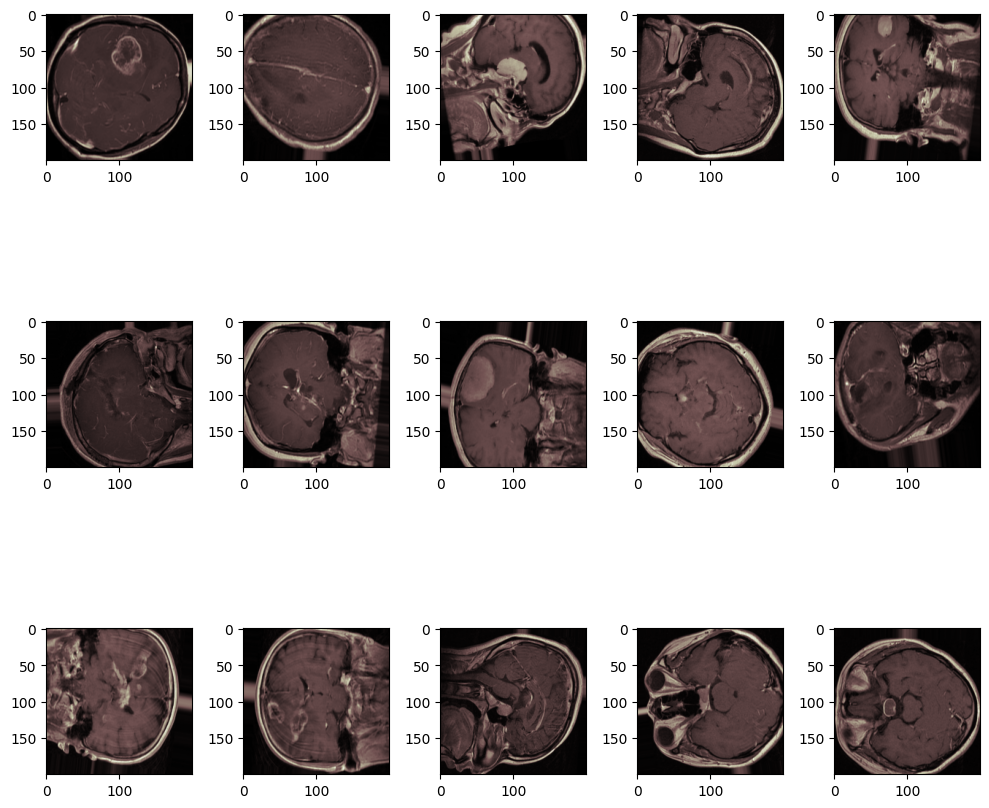

(614, 200, 200, 3)
(10536, 200, 200, 3)
(614, 3)
(10536, 3)


2023-12-10 00:24:25.524879: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-10 00:24:25.869367: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22134 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:c3:00.0, compute capability: 8.9


Epoch 1/50


2023-12-10 00:24:33.379118: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2023-12-10 00:24:33.915711: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2023-12-10 00:24:33.915752: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2023-12-10 00:24:33.915934: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-12-10 00:24:34.401657: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


264/264 [==============================] - ETA: 0s - loss: 0.6581 - accuracy: 0.7245
Epoch 1: saving model to model-MFLNet.h5
Epoch 1: 11.05 seconds
264/264 [==============================] - 11s 27ms/step - loss: 0.6581 - accuracy: 0.7245 - val_loss: 1.5128 - val_accuracy: 0.5066 - lr: 1.0000e-04
Epoch 2/50
262/264 [============================>.] - ETA: 0s - loss: 0.3556 - accuracy: 0.8598
Epoch 2: saving model to model-MFLNet.h5
Epoch 2: 6.00 seconds
264/264 [==============================] - 6s 23ms/step - loss: 0.3547 - accuracy: 0.8601 - val_loss: 3.7449 - val_accuracy: 0.5209 - lr: 1.0000e-04
Epoch 3/50
264/264 [==============================] - ETA: 0s - loss: 0.2686 - accuracy: 0.8943
Epoch 3: saving model to model-MFLNet.h5
Epoch 3: 6.17 seconds
264/264 [==============================] - 6s 23ms/step - loss: 0.2686 - accuracy: 0.8943 - val_loss: 0.3559 - val_accuracy: 0.8558 - lr: 1.0000e-04
Epoch 4/50
262/264 [============================>.] - ETA: 0s - loss: 0.2137 - accura

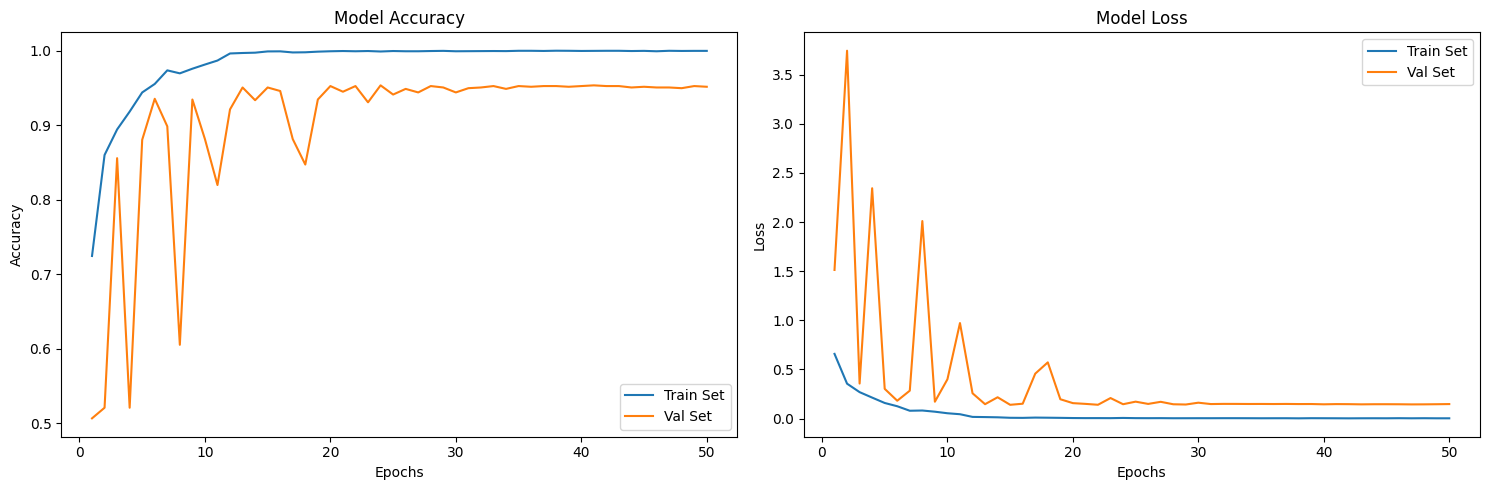

20/20 [==============================] - 0s 6ms/step - loss: 0.1731 - accuracy: 0.9446
Test Accuracy:  94.46
              precision    recall  f1-score   support

      glioma     0.9642    0.9406    0.9522       286
  meningioma     0.8966    0.9155    0.9059       142
   pituitary     0.9526    0.9731    0.9628       186

    accuracy                         0.9446       614
   macro avg     0.9378    0.9431    0.9403       614
weighted avg     0.9450    0.9446    0.9447       614



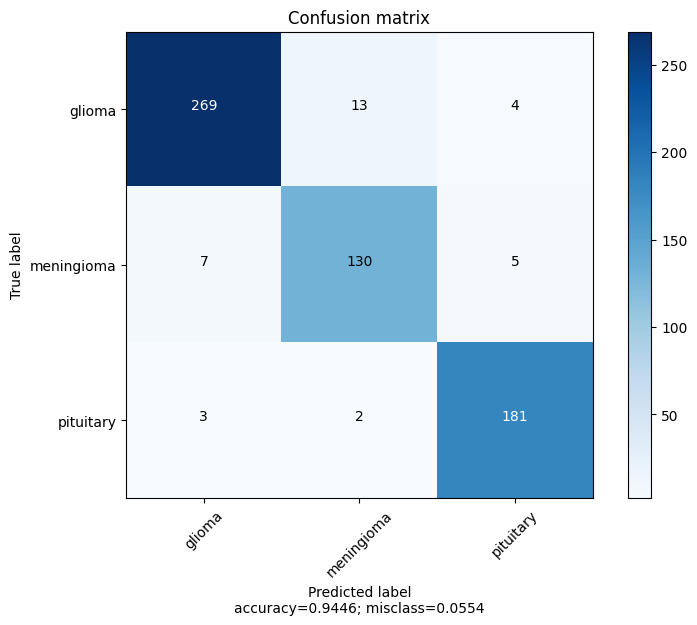

In [3]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)


model = MFL_Net()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir = 'logs')
Checkpoint = ModelCheckpoint(filepath='model-MFLNet.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='min')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,Checkpoint,reduce_lr, time_callback])


draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

%reset -f

100%|██████████| 186/186 [00:00<00:00, 197.29it/s]


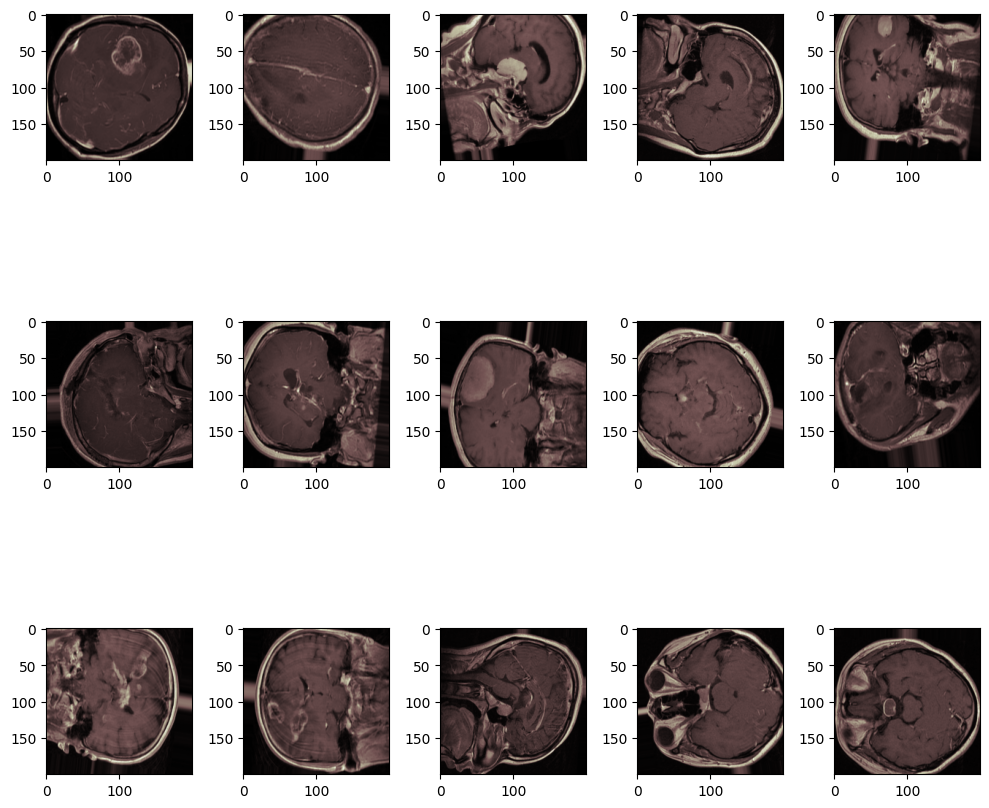

(614, 200, 200, 3)
(10536, 200, 200, 3)
(614, 3)
(10536, 3)
Epoch 1/50
264/264 [==============================] - ETA: 0s - loss: 0.6559 - accuracy: 0.7187
Epoch 1: saving model to model-MFLNet.h5
Epoch 1: 8.55 seconds
264/264 [==============================] - 9s 25ms/step - loss: 0.6559 - accuracy: 0.7187 - val_loss: 5.7622 - val_accuracy: 0.3321 - lr: 1.0000e-04
Epoch 2/50
262/264 [============================>.] - ETA: 0s - loss: 0.3670 - accuracy: 0.8598
Epoch 2: saving model to model-MFLNet.h5
Epoch 2: 5.97 seconds
264/264 [==============================] - 6s 23ms/step - loss: 0.3666 - accuracy: 0.8601 - val_loss: 7.5166 - val_accuracy: 0.3359 - lr: 1.0000e-04
Epoch 3/50
262/264 [============================>.] - ETA: 0s - loss: 0.2714 - accuracy: 0.8990
Epoch 3: saving model to model-MFLNet.h5
Epoch 3: 6.29 seconds
264/264 [==============================] - 6s 24ms/step - loss: 0.2713 - accuracy: 0.8989 - val_loss: 1.3757 - val_accuracy: 0.5939 - lr: 1.0000e-04
Epoch 4/50
262/2

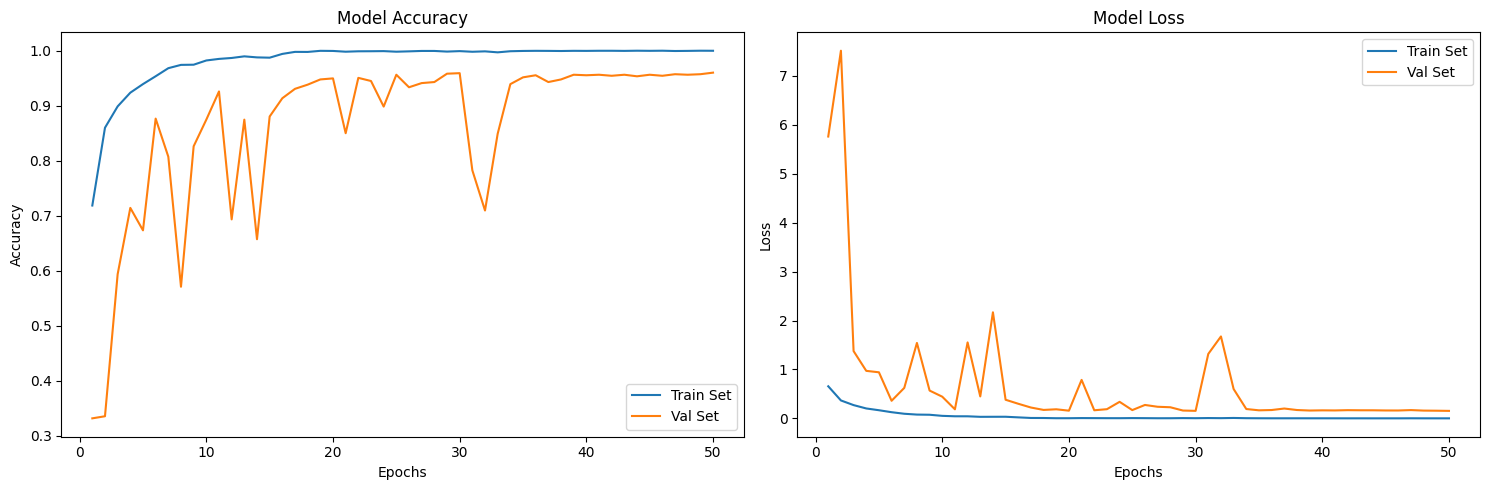

20/20 [==============================] - 0s 7ms/step - loss: 0.2207 - accuracy: 0.9479
Test Accuracy:  94.79
              precision    recall  f1-score   support

      glioma     0.9580    0.9580    0.9580       286
  meningioma     0.9225    0.9225    0.9225       142
   pituitary     0.9516    0.9516    0.9516       186

    accuracy                         0.9479       614
   macro avg     0.9441    0.9441    0.9441       614
weighted avg     0.9479    0.9479    0.9479       614



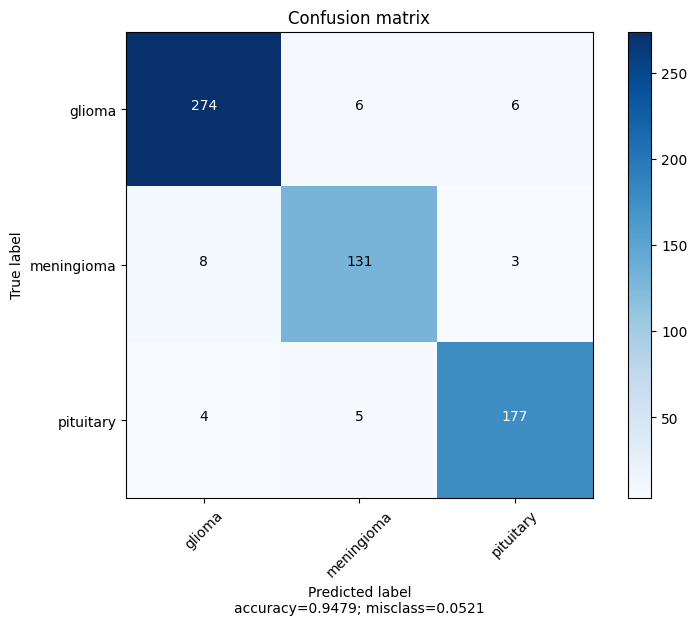

In [6]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)


model = MFL_Net()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir = 'logs')
Checkpoint = ModelCheckpoint(filepath='model-MFLNet.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='min')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,Checkpoint,reduce_lr, time_callback])


draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

%reset -f

100%|██████████| 186/186 [00:00<00:00, 194.55it/s]


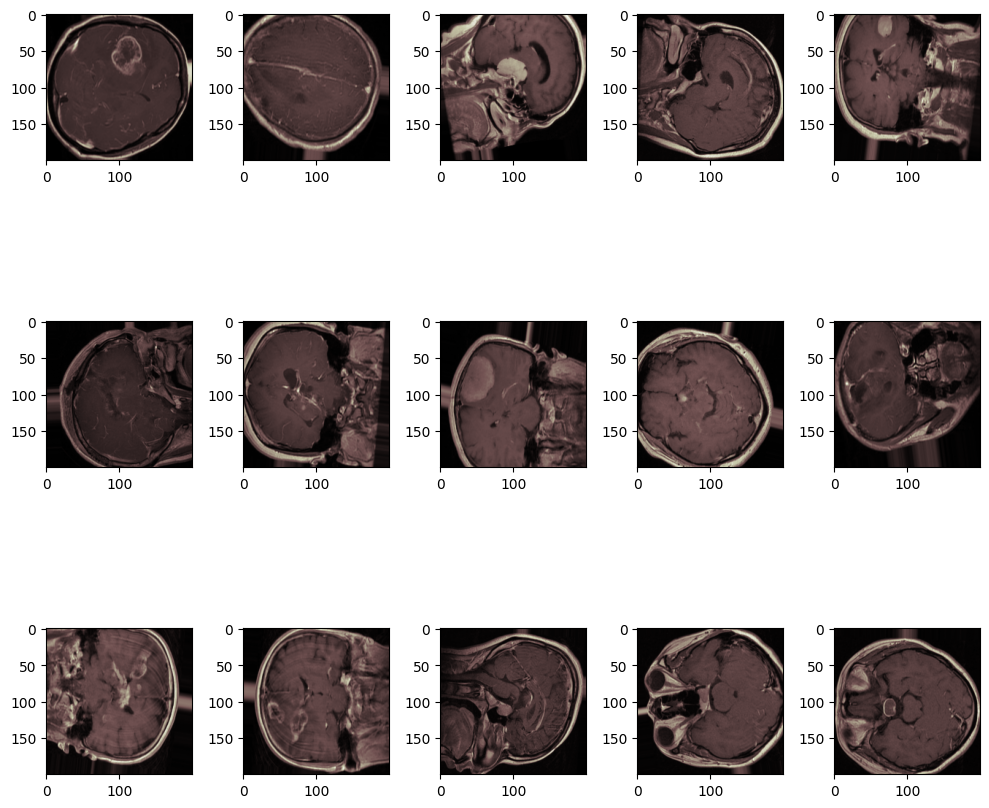

(614, 200, 200, 3)
(10536, 200, 200, 3)
(614, 3)
(10536, 3)


2023-12-10 00:46:53.129397: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-10 00:46:53.469301: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22134 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:c3:00.0, compute capability: 8.9


Epoch 1/50


2023-12-10 00:47:01.305349: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2023-12-10 00:47:01.896352: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2023-12-10 00:47:01.896386: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2023-12-10 00:47:01.896568: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-12-10 00:47:02.379034: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


264/264 [==============================] - ETA: 0s - loss: 0.6101 - accuracy: 0.7402
Epoch 1: saving model to model-MFLNet.h5
Epoch 1: 11.17 seconds
264/264 [==============================] - 11s 27ms/step - loss: 0.6101 - accuracy: 0.7402 - val_loss: 2.8132 - val_accuracy: 0.3425 - lr: 1.0000e-04
Epoch 2/50
262/264 [============================>.] - ETA: 0s - loss: 0.3842 - accuracy: 0.8497
Epoch 2: saving model to model-MFLNet.h5
Epoch 2: 5.99 seconds
264/264 [==============================] - 6s 23ms/step - loss: 0.3839 - accuracy: 0.8497 - val_loss: 3.5944 - val_accuracy: 0.5313 - lr: 1.0000e-04
Epoch 3/50
262/264 [============================>.] - ETA: 0s - loss: 0.2900 - accuracy: 0.8909
Epoch 3: saving model to model-MFLNet.h5
Epoch 3: 6.15 seconds
264/264 [==============================] - 6s 23ms/step - loss: 0.2899 - accuracy: 0.8913 - val_loss: 0.8647 - val_accuracy: 0.7287 - lr: 1.0000e-04
Epoch 4/50
262/264 [============================>.] - ETA: 0s - loss: 0.2321 - accura

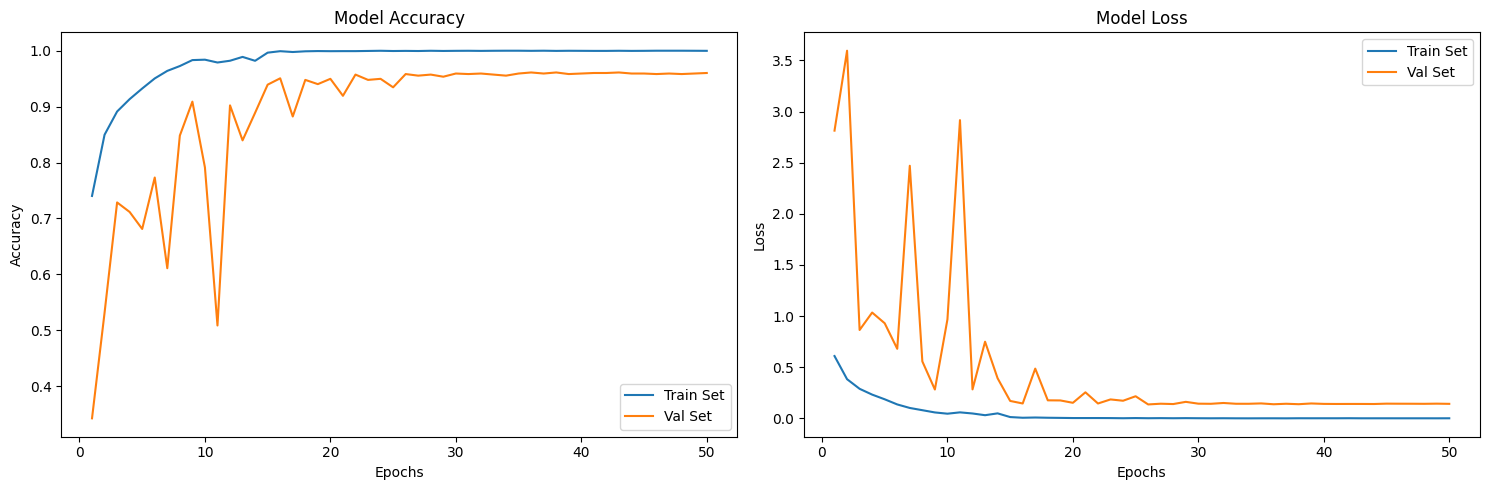

20/20 [==============================] - 0s 7ms/step - loss: 0.2030 - accuracy: 0.9479
Test Accuracy:  94.79
              precision    recall  f1-score   support

      glioma     0.9712    0.9441    0.9574       286
  meningioma     0.8919    0.9296    0.9103       142
   pituitary     0.9574    0.9677    0.9626       186

    accuracy                         0.9479       614
   macro avg     0.9402    0.9471    0.9435       614
weighted avg     0.9487    0.9479    0.9481       614



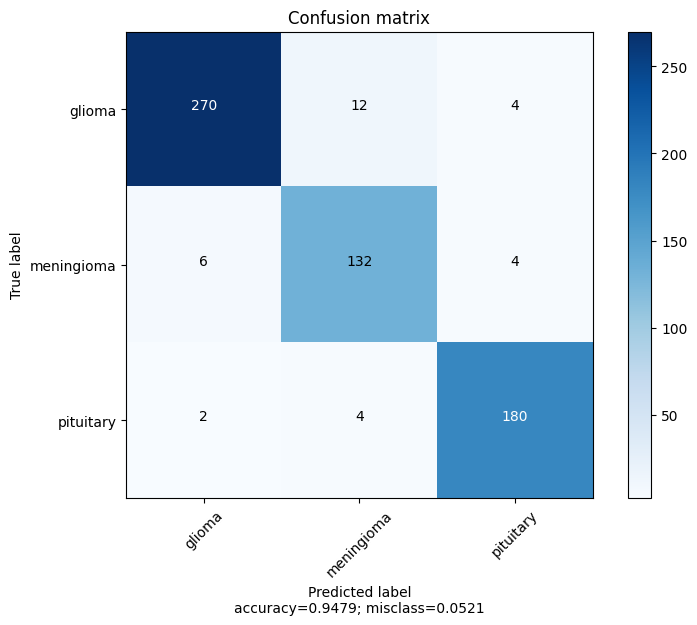

In [3]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)


model = MFL_Net()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir = 'logs')
Checkpoint = ModelCheckpoint(filepath='model-MFLNet.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='min')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,Checkpoint,reduce_lr, time_callback])


draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

%reset -f

100%|██████████| 186/186 [00:00<00:00, 194.96it/s]


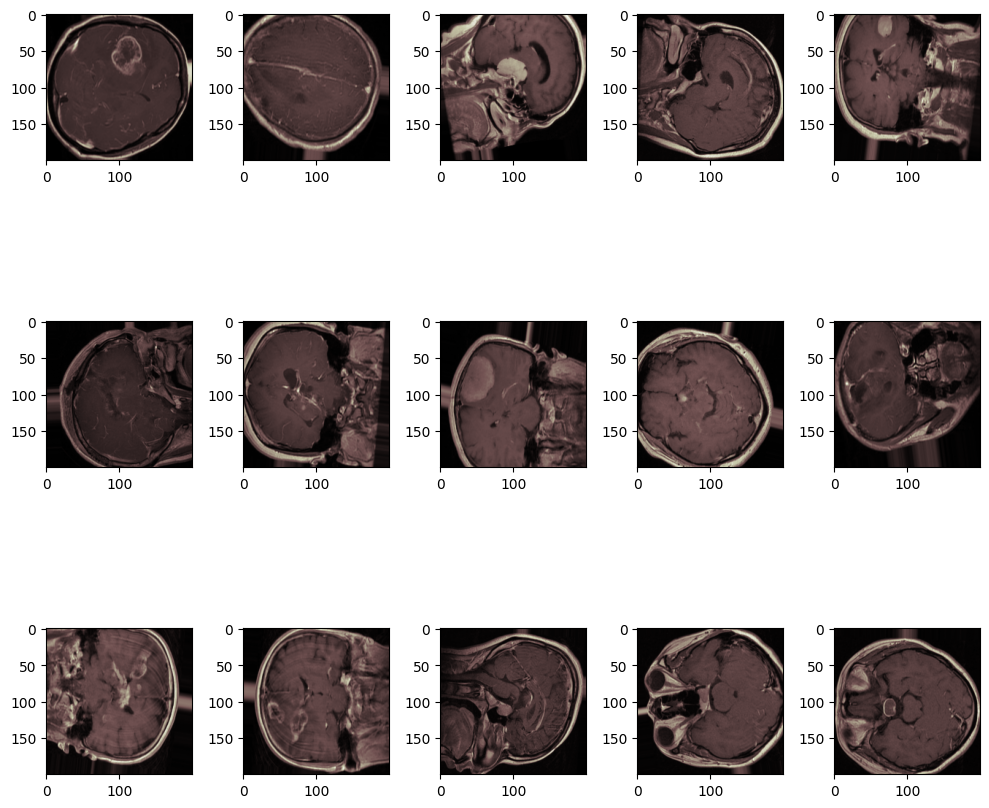

(614, 200, 200, 3)
(10536, 200, 200, 3)
(614, 3)
(10536, 3)
Epoch 1/50
262/264 [============================>.] - ETA: 0s - loss: 0.6621 - accuracy: 0.7213
Epoch 1: saving model to model-MFLNet.h5
Epoch 1: 9.05 seconds
264/264 [==============================] - 9s 26ms/step - loss: 0.6606 - accuracy: 0.7221 - val_loss: 1.3347 - val_accuracy: 0.4535 - lr: 1.0000e-04
Epoch 2/50
262/264 [============================>.] - ETA: 0s - loss: 0.3816 - accuracy: 0.8568
Epoch 2: saving model to model-MFLNet.h5
Epoch 2: 6.10 seconds
264/264 [==============================] - 6s 23ms/step - loss: 0.3804 - accuracy: 0.8573 - val_loss: 5.8990 - val_accuracy: 0.3577 - lr: 1.0000e-04
Epoch 3/50
262/264 [============================>.] - ETA: 0s - loss: 0.2885 - accuracy: 0.8939
Epoch 3: saving model to model-MFLNet.h5
Epoch 3: 6.06 seconds
264/264 [==============================] - 6s 23ms/step - loss: 0.2884 - accuracy: 0.8939 - val_loss: 0.5396 - val_accuracy: 0.7808 - lr: 1.0000e-04
Epoch 4/50
262/2

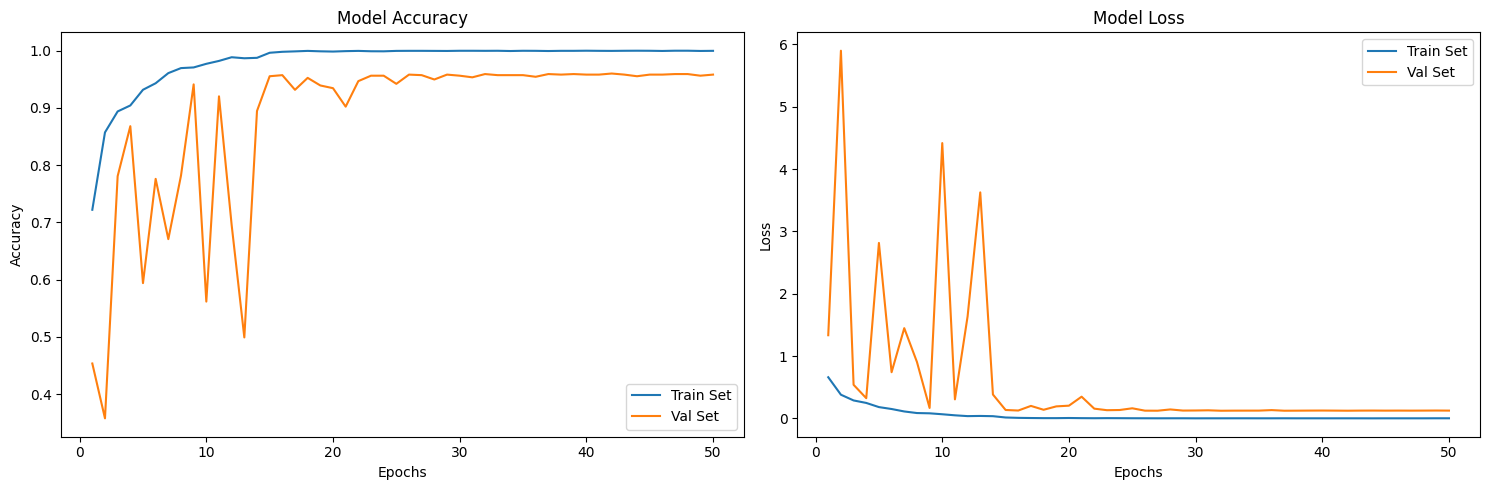

20/20 [==============================] - 0s 7ms/step - loss: 0.1708 - accuracy: 0.9332
Test Accuracy:  93.32
              precision    recall  f1-score   support

      glioma     0.9574    0.9441    0.9507       286
  meningioma     0.8803    0.8803    0.8803       142
   pituitary     0.9368    0.9570    0.9468       186

    accuracy                         0.9332       614
   macro avg     0.9249    0.9271    0.9259       614
weighted avg     0.9334    0.9332    0.9332       614



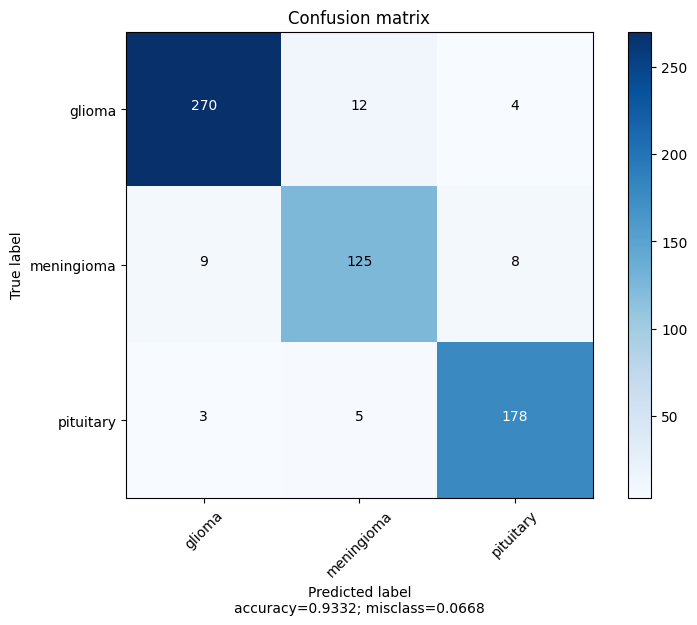

In [6]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)


model = MFL_Net()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir = 'logs')
Checkpoint = ModelCheckpoint(filepath='model-MFLNet.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='min')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,Checkpoint,reduce_lr, time_callback])


draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)